In [1]:
from beakerx.object import beakerx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv("Data/mnist_train.csv")
y = df.label
x = df.drop("label", axis=1)
x = x.values.reshape(60000,28,28)

In [3]:
def scale(X, x_min=0, x_max=1):
    nom = (X-X.min())*(x_max-x_min)
    denom = X.max() - X.min()
    denom = denom + (denom is 0)
    return x_min + nom/denom

In [4]:
def one_hot_enc(y):
    b = np.zeros(y.size, y.max()+1)
    b[np.arange(y.size), y] = 1
    return b

In [5]:
x = scale(x)

In [6]:
enc = OneHotEncoder()
y = enc.fit_transform(y.values.reshape(-1,1)).toarray()

In [7]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [626]:
class Dense:
    def __init__(self, h_layers, n_outputs, img_rows, img_cols, act_funcs=[]):
        self.img_size = img_rows * img_cols
        self.h_layers = h_layers.append(n_outputs) # Done this way for clarity of user
        self.n_layers = len(h_layers)
        if act_funcs:
            self.act_funcs = []
            for act_func in act_funcs:
                if act_func == "relu":
                    self.act_funcs.append(self.relu)
                elif act_func == "sigmoid":
                    self.act_funcs.append(self.sigmoid)
                elif act_func == "sofmax":
                    self.act_funcs.append(self.softmax)
        else:
            self.act_funcs = [self.relu for _ in range(self.n_layers)]
            self.act_funcs[-1] = self.sigmoid
        act_func_dict = {self.relu: self.relu_prime, self.sigmoid: self.sigmoid_prime, self.softmax: self.softmax_prime}
        self.act_funcs_prime = []
        for func in self.act_funcs:
            self.act_funcs_prime.append(act_func_dict[func])
        assert len(self.act_funcs) == self.n_layers

        # initialize weights with std. deviation that divides the random initializations by the sqrt of the number of inputs / 2
        # see cs231n Andrej Karpathy time-stamp 49:00 https://youtu.be/gYpoJMlgyXA?t=2942
        self.weights = [np.random.randn(self.img_size,h_layers[0]) / np.sqrt(self.img_size/2)]
        for i in range(self.n_layers-1):
            self.weights.append(np.random.randn(h_layers[i], h_layers[i+1]) / np.sqrt(h_layers[i] / 2))
        self.weights = np.array(self.weights)
        self.biases = np.array([np.random.randn(y) for y in h_layers])
        self.train_error = []


    def forward(self, inp, train=False):
        zipped = list(zip(self.biases, self.weights))
        if train:
            z = []
            a = [inp]
            for i in range(self.n_layers):
                b,w = zipped[i]
                inp = np.dot(inp, w) + b
                z.append(inp)
                inp = self.act_funcs[i](inp)
                a.append(inp)
            return a, z
        else:
            for i in range(self.n_layers):
                b,w = zipped[i]
                inp = self.act_funcs[i](np.dot(inp, w) + b) 
            return inp

    def train(self, data, labels, epochs=1000, batch_size=100):
        self.data = data
        self.labels = labels
        self.batch_error = []

        # TODO feed each image and track avg error. Compute gradient and backprop. 

        for _ in range(epochs):
            x_batch, y_batch =  self._get_batch(batch_size)
            batch_d_b = []
            batch_d_w = []
            for img, label in zip(x_batch, y_batch):
                a, z = self.forward(img, train=True)
                img_d_b = []
                img_d_w = []

                loss = (a[-1] - label) ** 2
                self.batch_error.append(loss.mean())
                
                # set the final activ. grad. to deriv of loss function evaluated with activation of final layer == result of network 
                d_a = [(a[-1] - label) * 2]
                d_z = [] # list for derivaties of z_nodes
                for i in range(1,len(z)+1):
                    # d_a[-1]
                    #evaluate the derivative of z_nodes using the derivative of the activ. func used, evaluated at zL, and mult. by the leading grad, because of chain rule, that is stored at d_a[i]
                    d_z = self.act_funcs_prime[-i](z[-i]) * d_a[i-1]

                    img_d_b.append(d_z) # The grad. of biases is just that of z_nodes
                    img_d_w.append(d_z * a[-i])
                    d_a.append(np.dot(d_z, self.weights[-i].T))
                batch_d_b.append(np.array(img_d_b))
                batch_d_w.append(np.array(img_d_w))
            
            batch_d_w = np.array(batch_d_w).mean(axis=0) * .01
            batch_d_b = np.array(batch_d_b).mean(axis=0) * .01

            self.weights = self.weights - batch_d_w[::-1]
            self.biases = self.biases - batch_d_b[::-1]
                

            self.train_error.append(np.array(self.batch_error).mean())



    def _get_batch(self, batch_size):
        indices = np.random.randint(len(self.data), size=batch_size)
        return self.data[indices].reshape(batch_size, 784), self.labels[indices]


    def relu(self, inp):
        return np.maximum(inp,  0)
    def relu_prime(self, inp):
        inp[inp<=0] = 0
        inp[inp>0] = 1
        return inp

    def softmax(self, inp):
        return (np.e ** inp) / (sum(np.e ** inp))
    def softmax_prime(self, inp):
        pass

    def sigmoid(self, inp):
        return 1.0/(1.0+np.exp(-inp))
    def sigmoid_prime(self, inp):
        return self.sigmoid(inp) * (1 - self.sigmoid(inp))



In [627]:
temp = Dense([16,16], 10, *test_pic.shape, ["sigmoid", "sigmoid", "sigmoid"])

In [628]:
temp.train(x, y, 500, 10)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


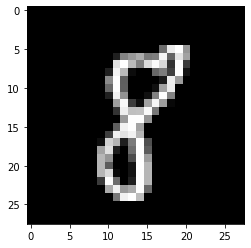

In [635]:
random_selec = np.random.randint(0,len(x))
test_pic = x[random_selec]
test_pic_y = y[random_selec]
plt.imshow(test_pic, cmap="gray")
print(test_pic_y)

In [636]:
temp_out = temp.forward(test_pic.reshape(784))

In [637]:
print(temp_out.argmax())
print(temp_out)

1
[0.18144572 0.21348841 0.18417232 0.19120381 0.18717188 0.1024964
 0.02358902 0.18071941 0.18064683 0.15260456]


In [ ]:
[w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]

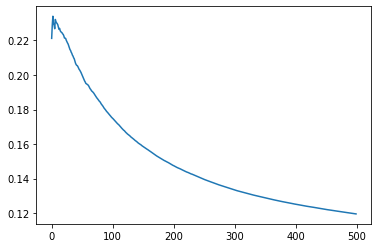

In [638]:
plt.plot(temp.train_error)